In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import sys
from os import path
sys.path.insert(0, "../ISANet/")
sys.path.insert(0, "./")

from isanet.model import Mlp
from isanet.optimizer import SGD, NCG, LBFGS
from isanet.optimizer.utils import l_norm
from isanet.datasets.monk import load_monk
from isanet.utils.model_utils import printMSE, printAcc, plotHistory
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
def get_fitted_model(X_train, Y_train, optimizer, n_seed = 189, verbose = 1):
    np.random.seed(seed=n_seed)
    print("Build the model")
    reg = 1e-4
    model = Mlp()
    model.add(4, input= 17, kernel_initializer = 0.003, kernel_regularizer = reg)
    model.add(1, kernel_initializer = 0.003, kernel_regularizer = reg)

    print("norm_w0: {}".format(l_norm(model.weights)))
    print("sum_w0: {}".format([np.sum(np.square(x)) for x in model.weights]))
    model.set_optimizer(optimizer)
    start = time.time()
    model.fit(X_train,
            Y_train, 
            epochs=1000, 
            verbose=verbose)
    end = time.time()
    return model, (end - start)

def ls_stat(info):
    converged = 0
    tot_iteration = 0
    tot = len(info["ls_conv"])
    for i in range(tot):
        tot_iteration += info["ls_it"][i] + info["zoom_it"][i]
        if info["ls_conv"][i] == "y":
            converged += 1
    
    print("Ls Hit Rate: {}".format(converged/tot))
    print("Ls iteration: {}".format(tot_iteration))

# Monk3 ln_maxtier 100

In [3]:
print("Load Monk DataSet")
X_train, Y_train = load_monk("3", "train")

seed = 353
ln_maxiter = 100
results = []
eps = 1e-7

Load Monk DataSet


In [4]:
#############################
#          NCG hs
#############################

optimizer = NCG(beta_method="hs", c1=1e-4, c2=.1, ln_maxiter = ln_maxiter, norm_g_eps = eps, l_eps = eps)

model, t = get_fitted_model(X_train, Y_train, optimizer, seed, 2)
print("Time: {}".format(t))
print("Ls Time: {}".format(np.sum(optimizer.history["ls_time"])))
ls_stat(optimizer.history)
h_hs = model.history 

Build the model
norm_w0: 0.014038075711776659
sum_w0: [0.00018936875436216934, 7.698815327404412e-06]
| beta: 0 | alpha: 4.0 | ng: 0.005852828240760246 | ls conv: y, it: 2, time: 0.0014 | zoom used: n, conv: -, it: 0|
Epoch: 1 - time: 0.0527 - loss_train: 0.2499312690401121 - loss_val: 0
| beta: 0.007576756431697875 | alpha: 35918.921157016084 | ng: 0.00048306045074117317 | ls conv: y, it: 16, time: 0.0199 | zoom used: y, conv: y, it: 1|
Epoch: 2 - time: 0.0231 - loss_train: 0.1272117219987731 - loss_val: 0
| beta: 15152.820352429786 | alpha: 0.10995498818988889 | ng: 0.05962964538740184 | ls conv: y, it: 0, time: 0.0015 | zoom used: y, conv: y, it: 1|
Epoch: 3 - time: 0.0027 - loss_train: 0.12701932427646295 - loss_val: 0
| beta: -0.060680845286273134 | alpha: 13.76828474500143 | ng: 0.055776180019281286 | ls conv: y, it: 4, time: 0.0053 | zoom used: y, conv: y, it: 1|
Epoch: 4 - time: 0.0066 - loss_train: 0.09870450117445528 - loss_val: 0
| beta: -0.13730244558867394 | alpha: 43.3193

In [5]:
#############################
#          NCG hs+
#############################

optimizer = NCG(beta_method="hs+", c1=1e-4, c2=.1, ln_maxiter = ln_maxiter, norm_g_eps = eps, l_eps = eps)

model, t = get_fitted_model(X_train, Y_train, optimizer, seed, 2)
print("Time: {}".format(t))
print("Ls Time: {}".format(np.sum(optimizer.history["ls_time"])))
ls_stat(optimizer.history)
h_hs_plus = model.history 

Build the model
norm_w0: 0.014038075711776659
sum_w0: [0.00018936875436216934, 7.698815327404412e-06]
| beta: 0 | alpha: 4.0 | ng: 0.005852828240760246 | ls conv: y, it: 2, time: 0.0135 | zoom used: n, conv: -, it: 0|
Epoch: 1 - time: 0.0199 - loss_train: 0.2499312690401121 - loss_val: 0
| beta: 0.007576756431697875 | alpha: 35918.921157016084 | ng: 0.00048306045074117317 | ls conv: y, it: 16, time: 0.0491 | zoom used: y, conv: y, it: 1|
Epoch: 2 - time: 0.0818 - loss_train: 0.1272117219987731 - loss_val: 0
| beta: 15152.820352429786 | alpha: 0.10995498818988889 | ng: 0.05962964538740184 | ls conv: y, it: 0, time: 0.0026 | zoom used: y, conv: y, it: 1|
Epoch: 3 - time: 0.0074 - loss_train: 0.12701932427646295 - loss_val: 0
| beta: 0 | alpha: 21.89155659502987 | ng: 0.055776180019281286 | ls conv: y, it: 5, time: 0.0078 | zoom used: y, conv: y, it: 0|
Epoch: 4 - time: 0.0105 - loss_train: 0.09956532549774585 - loss_val: 0
| beta: 0.05343669037359769 | alpha: 128.0 | ng: 0.01111188616081

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


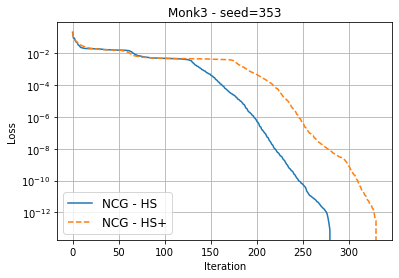

In [6]:
pos_train = (0,0)
figsize = (12, 4)

plt.plot(h_hs["loss_mse_reg"] - h_hs["loss_mse_reg"][-1], linestyle='-')
plt.plot(h_hs_plus["loss_mse_reg"] - h_hs_plus["loss_mse_reg"][-1], linestyle = '--')
plt.title('Monk3 - seed={}'.format(seed))
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - HS','NCG - HS+'], loc='lower left', fontsize='large')
plt.savefig('./plot/monk3_hs_hs+.eps', format='eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


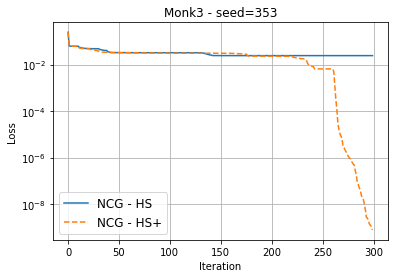

In [60]:
pos_train = (0,0)
figsize = (12, 4)

plt.plot(h_hs["loss_mse"][:300], linestyle='-')
plt.plot(h_hs_plus["loss_mse"][:300], linestyle = '--')
plt.title('Monk3 - seed={}'.format(seed))
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - HS','NCG - HS+'], loc='lower left', fontsize='large')
plt.savefig('./plot/monk3_hs_hs+_zommed.eps', format='eps')
plt.show()

# Old exp

# Monk 3 ln_maxiter = 10

In [11]:
print("Load Monk DataSet")
X_train, Y_train = load_monk("3", "train")

seed = 874
ln_maxiter = 10
results = []

Load Monk DataSet


In [12]:
#############################
#          NCG hs
#############################
optimizer = NCG(beta_method="hs", c1=1e-4, c2=.9, ln_maxiter = ln_maxiter, norm_g_eps = 1e-9, l_eps = 1e-9)
model = get_fitted_model(X_train, Y_train, optimizer, seed, 1)
h_hs = model.history 

Build the model
norm_w0: 0.015095228650121514
sum_w0: [0.00022021050880704037, 7.655419192409051e-06]
Epoch: 1 - time: 0.0064 - loss_train: 0.2499370294898889 - loss_val: 0
Epoch: 2 - time: 0.0020 - loss_train: 0.24992231276947047 - loss_val: 0
Epoch: 3 - time: 0.0037 - loss_train: 0.24990195326797435 - loss_val: 0
Epoch: 4 - time: 0.0098 - loss_train: 0.06855361477744959 - loss_val: 0
Epoch: 5 - time: 0.0031 - loss_train: 0.06643681862712746 - loss_val: 0
Epoch: 6 - time: 0.0069 - loss_train: 0.061559252838557094 - loss_val: 0
Epoch: 7 - time: 0.0044 - loss_train: 0.06124724342177736 - loss_val: 0
Epoch: 8 - time: 0.0091 - loss_train: 0.06117858481488383 - loss_val: 0
Epoch: 9 - time: 0.0053 - loss_train: 0.06116083631272743 - loss_val: 0
Epoch: 10 - time: 0.0043 - loss_train: 0.06113436000199139 - loss_val: 0
Epoch: 11 - time: 0.0048 - loss_train: 0.06112561069598583 - loss_val: 0
Epoch: 12 - time: 0.0112 - loss_train: 0.06111219038625418 - loss_val: 0
Epoch: 13 - time: 0.0029 - loss

KeyboardInterrupt: 

In [145]:
#############################
#          NCG hs+
#############################

optimizer = NCG(beta_method="hs+", c1=1e-4, ln_maxiter = ln_maxiter, c2=.9, tol = 1e-14)

model = get_fitted_model(X_train, Y_train, optimizer, seed, 1)
h_hs_plus = model.history 

Build the model

Alpha: 0.08743317943303316 - norm_g: 3.4422283382295005
Epoch: 1 - time: 0.0040 - loss_train: 0.25072239457813345 - loss_val: 0

Beta: 0.3600638390538469 -> compute alpha: Alpha: 1.0 - norm_g: 1.4003295946052992
Epoch: 2 - time: 0.0030 - loss_train: 0.24214306689943602 - loss_val: 0

Beta: 6.869030972050874 -> compute alpha: Alpha: 0.499889233606507 - norm_g: 1.878745159480073
Epoch: 3 - time: 0.0030 - loss_train: 0.21837996724306022 - loss_val: 0

Beta: 12.147526639992973 -> compute alpha: Alpha: 1.0 - norm_g: 9.195592513638971
Epoch: 4 - time: 0.0020 - loss_train: 0.0655685683512261 - loss_val: 0

Beta: 0 -> compute alpha: Alpha: 8.0 - norm_g: 0.004268580049303031
Epoch: 5 - time: 0.0030 - loss_train: 0.06556634671785232 - loss_val: 0

Beta: 0 -> compute alpha: Alpha: 8.0 - norm_g: 0.0036967708087792686
Epoch: 6 - time: 0.0040 - loss_train: 0.06556465191944187 - loss_val: 0

Beta: 0 -> compute alpha: Alpha: 16.0 - norm_g: 0.0033120875243242798
Epoch: 7 - time: 0.0050

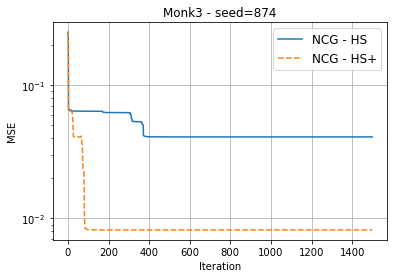

In [146]:
pos_train = (0,0)
figsize = (12, 4)

plt.plot(h_hs["loss_mse"], linestyle='-')
plt.plot(h_hs_plus["loss_mse"], linestyle = '--')
plt.title('Monk3 - seed={}'.format(seed))
plt.ylabel("MSE")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - HS','NCG - HS+'], loc='upper right', fontsize='large')    
plt.show()


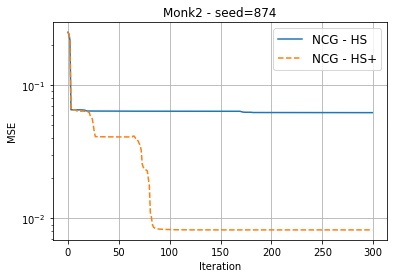

In [147]:
pos_train = (0,0)
figsize = (12, 4)
zoom = 300
plt.plot(h_hs["loss_mse"][:zoom], linestyle='-')
plt.plot(h_hs_plus["loss_mse"][:zoom], linestyle = '--')
plt.title('Monk2 - seed={}'.format(seed))
plt.ylabel("MSE")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - HS','NCG - HS+'], loc='upper right', fontsize='large')    
plt.show()

In [151]:
print("Load Monk DataSet")
X_train, Y_train = load_monk("3", "train")

seed = 435
ln_maxiter = 10
results = []

#############################
#          NCG hs
#############################

optimizer = NCG(beta_method="hs", c1=1e-4, ln_maxiter = ln_maxiter, c2=.9, tol = 1e-14)

model = get_fitted_model(X_train, Y_train, optimizer, seed, 1)
h_hs = model.history 

#############################
#          NCG hs+
#############################

optimizer = NCG(beta_method="hs+", c1=1e-4, ln_maxiter = ln_maxiter, c2=.9, tol = 1e-14)

model = get_fitted_model(X_train, Y_train, optimizer, seed, 1)
h_hs_plus = model.history 

Load Monk DataSet
Build the model

Alpha: 0.0878795241595134 - norm_g: 3.366455624846799
Epoch: 1 - time: 0.0030 - loss_train: 0.24377975992695797 - loss_val: 0

Beta: 0.3937266541900837 -> compute alpha: Alpha: 4.0 - norm_g: 1.8299951976957993
Epoch: 2 - time: 0.0040 - loss_train: 0.07298988090429187 - loss_val: 0

Beta: 0.5241204909758831 -> compute alpha: Alpha: 0.4957954990234208 - norm_g: 1.7044407167868687
Epoch: 3 - time: 0.0030 - loss_train: 0.07102707996333596 - loss_val: 0

Beta: 2.6187435573288833 -> compute alpha: Alpha: 1.0 - norm_g: 3.3655389297680545
Epoch: 4 - time: 0.0020 - loss_train: 0.056453785567773 - loss_val: 0

Beta: 0.6440453305306072 -> compute alpha: Alpha: 0.6183902294245345 - norm_g: 1.2679269719623265
Epoch: 5 - time: 0.0040 - loss_train: 0.041947334508807145 - loss_val: 0

Beta: -0.1806108568439679 -> compute alpha: Alpha: 0.498447844631607 - norm_g: 0.6522912117541796
Epoch: 6 - time: 0.0030 - loss_train: 0.04060036988522503 - loss_val: 0

Beta: 2.793315

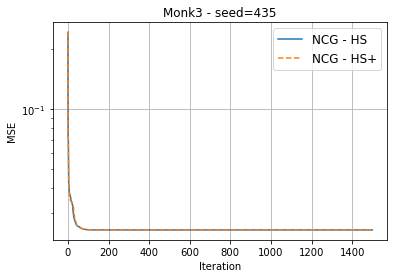

In [152]:
pos_train = (0,0)
figsize = (12, 4)

plt.plot(h_hs["loss_mse"], linestyle='-')
plt.plot(h_hs_plus["loss_mse"], linestyle = '--')
plt.title('Monk3 - seed={}'.format(seed))
plt.ylabel("MSE")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - HS','NCG - HS+'], loc='upper right', fontsize='large')    
plt.show()


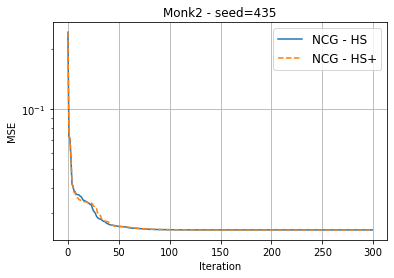

In [153]:
pos_train = (0,0)
figsize = (12, 4)
zoom = 300
plt.plot(h_hs["loss_mse"][:zoom], linestyle='-')
plt.plot(h_hs_plus["loss_mse"][:zoom], linestyle = '--')
plt.title('Monk2 - seed={}'.format(seed))
plt.ylabel("MSE")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - HS','NCG - HS+'], loc='upper right', fontsize='large')    
plt.show()